In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
import stwave as st
import math
from cskf import CSKF
import DNN_Net

Using TensorFlow backend.


In [2]:
def generate_Q(xmin, dx,length_x, nx, L, kernel= 'Gaussian'):
    """
    Generate covariance matrix for the given 2D grid

    inputs:
    @ xmin:   a list containing minimum values for x and y coordinates, [x_1, x_2].
    @ dx      a list containing the increment in the x and y directions.
    @ dx:     a list containing the length of domain in the x and y directions.
    @ nx:     a list containing the number of cells in the x and y directions.
    @ L:      a list containing the length scale in the x and y directions.
    Kernel:   The type of kernel for the covariance matrix
    
    Output:
    Q:        Covariance matrix
    """
    
    xr = np.linspace(xmin[0]+.5*dx[0],  xmin[0]+length_x[0]-.5*dx[0], nx[0])
    yr = np.linspace(xmin[1]+.5*dx[1],  xmin[1]+length_x[1]-.5*dx[1],nx[1])
    x, y = np.meshgrid(xr, yr)
    x1, x2 = np.meshgrid(x, x)
    y1, y2 = np.meshgrid(y,y)
    distance_x = (x1-x2)**2
    distance_y = (y1-y2)**2
    distance = distance_x/(L[0]**2)+distance_y/(L[1]**2)
    if kernel == 'Gaussian':
        Q = np.exp(-distance)
    elif kernel == 'Exponential':
        Q = np.exp(-np.sqrt(distance))
    else:
        raise NotImplementedError
        
	return Q

def initializer_dist(bc_l, nx, distribution = 'linear', bc_r = None):
    """
    Generates an initial bathymetry distribution for the domain
    
    inputs:
    @ bc_l               Bathymetry value at left (near the shore)
    @ nx                 a list containing the length of domain in the x and y directions.
    @ distribution:      Type of distribution for the initial condition
    
    """
    
    
    if distribution == 'linear':
        linear_variation = np.linspace(bc_l, bc_r, nx[0]).reshape(1,nx[0])
        Initial_dist = np.ones((nx[1],nx[0]))*linear_variation
        Initial_dist = Initial_dist.reshape(nx[0]*nx[1],1)
    else:
        raise NotImplementedError

    return Initial_dist
    
def forward_model(s, parallel, ncores=None):
	model = st.Model()
	if parallel:
		simul_obs = model.run(s, parallel, ncores)
	else:
		simul_obs = model.run(s, parallel)
	return simul_obs

def observation_model(x, H, lin):
	if lin == 'linear':
		return np.dot(H, x)
	if lin == 'non_linear':
		return np.dot(H, np.sqrt(x))
    
def create_sub_samples(prof_vel, prof_dep, rec_len, nx):
    
    """
    This function will get the wave celerity and bathymetry values for the whole domain and generate a two dimentional 
    numpy arrays X and a 1D numpy array y. The i'th column of X contains the wave celerity values in a square with length 'rec_len' around the
    i'th grid point. The y(i) contains the bathymetry value corresponding to i'th grid point.
    
    inputs:
    
    @ prof_vel:         a 2D numpy array containg the wave celerity for the domain
    @ prof_dep:         a 2D numpy array containg the depth for the domain
    @ rec_len:          The length of the square around each grid point for measuring wave celerity. rec_len should be an odd integer
    @ nx                a list containing the length of domain in the x and y directions.
    
    outputs:
    X:                  2D numpy array of size (rec_len**2, N) containing the wave celerity (inputs of DNN)
    y:                  1D numpy array of size (N, ) containing the bathymetry values (outputs of DNN)
    """
    
    n_prof = prof_vel.shape[1]
    n_sample_per_prof = (nx[1]-rec_len+1)*(nx[0]-rec_len+1)
    n_sample = n_sample_per_prof*n_prof
    X = np.zeros((rec_len**2, n_sample))
    #print(X.shape)
    y = np.zeros((n_sample,1))
    kk=0
    for i in range(n_prof):
        dom_vel = np.reshape(prof_vel[:,i], (nx[1],nx[0]))
        dom = np.reshape(prof_dep[:,i], (nx[1],nx[0]))
        for j in range((rec_len-1)//2, nx[0]-((rec_len-1)//2)):
            for k in range((rec_len-1)//2, nx[1]-((rec_len-1)//2)):
                X[:,kk] = dom_vel[k-(rec_len-1)//2:k+(rec_len-1)//2+1, j-(rec_len-1)//2:j+(rec_len-1)//2+1].ravel()
                y[kk]= dom[k,j]
                kk+=1
    
    return X, y


def create_sub_samples_test(prof_vel, rec_len, nx):
    
    """
    This function will get the wave celerity and bathymetry values for the whole domain and generate a two dimentional 
    numpy arrays X and a 1D numpy array y. The i'th column of X contains the wave celerity values in a square with length 'rec_len' around the
    i'th grid point. The y(i) contains the bathymetry value corresponding to i'th grid point.
    
    inputs:
    
    @ prof_vel:         a 2D numpy array containg the wave celerity for the domain
    @ prof_dep:         a 2D numpy array containg the depth for the domain
    @ rec_len:          The length of the square around each grid point for measuring wave celerity. rec_len should be an odd integer
    @ nx                a list containing the length of domain in the x and y directions.
    
    outputs:
    X:                  2D numpy array of size (rec_len**2, N) containing the wave celerity (inputs of DNN)
    y:                  1D numpy array of size (N, ) containing the bathymetry values (outputs of DNN)
    """
    
    n_prof = prof_vel.shape[1]
    n_sample_per_prof = (nx[1]-rec_len+1)*(nx[0]-rec_len+1)
    n_sample = n_sample_per_prof*n_prof
    X = np.zeros((rec_len**2, n_sample))
    #print(X.shape)
    y = np.zeros((n_sample,1))
    kk=0
    for i in range(n_prof):
        dom_vel = np.reshape(prof_vel[:,i], (nx[1],nx[0]))
        for j in range((rec_len-1)//2, nx[0]-((rec_len-1)//2)):
            for k in range((rec_len-1)//2, nx[1]-((rec_len-1)//2)):
                X[:,kk] = dom_vel[k-(rec_len-1)//2:k+(rec_len-1)//2+1, j-(rec_len-1)//2:j+(rec_len-1)//2+1].ravel()
                kk+=1
    
    return X



def generate_training_data(n_dom, min_bc_l, max_bc_l, nx, rec_len, A, sig_obs, save_data = True):
    
    """
    Generates synhetic training data by creating n_dom bathymetry profiles and then creating X and y arrays by calling 
    create_sub_samples function for each domain.
    
    
    """
    
    bc_r = 0
    bc_l = np.linspace(min_bc_l, max_bc_l, n_dom)
    distribution = "linear"
    initial_dist = initializer_dist(bc_l[0], bc_r, nx, distribution)
    obs_vel = forward_model(initial_dist, parallel=False)
    bathy = np.array(initial_dist).reshape(1,-1)
    obs = np.array(obs_vel).reshape(1,-1)
    obs_vel = obs_vel +np.random.randn(110*83,1)*sig_obs
    X_tr,y_tr = create_sub_samples(obs_vel,initial_dist, rec_len, nx)
    X_tr = X_tr.T
    for i in range(n_dom):
        initial_dist = initializer_dist(bc_l[i], bc_r, nx, distribution)
        b=np.dot(A.T,np.random.randn(110*83,1))*.05
        input_bathy = initial_dist+b
        obs_vel = forward_model(input_bathy, parallel=False)
        obs_true = obs_vel.reshape(1,-1)
        obs_vel = obs_vel +np.random.randn(110*83,1)*sig_obs
        X_obs,y_obs = create_sub_samples(obs_vel,input_bathy, rec_len, nx)
        X_tr = np.concatenate((X_tr,X_obs.T), axis=0)
        y_tr = np.concatenate((y_tr,y_obs), axis=0)
        bathy = np.concatenate((bathy,input_bathy.reshape(1,-1)), axis =0)
        obs = np.concatenate((obs,obs_true), axis =0)
    if save_data:
        savemat('training_data.mat',{'X_tr': X_tr, 'y_tr': y_tr})
        savemat('training_data_whole_domain.mat',{'bathy': bathy, 'obs': obs})
    
    return X_tr, y_tr

def generate_test_data(rec_len, A, nx, sig_obs, save_data = True):

    data = loadmat('true_depth.mat', squeeze_me=True)
    ref_bathy = data['true']
    ref_bathy[ref_bathy<0.01] = 0.01
    ref_bathy = ref_bathy.reshape(-1,1)
    obs_vel = forward_model(ref_bathy, parallel=False)
    obs_vel = obs_vel +np.random.randn(110*83,1)*.1
    X_test,y_test = create_sub_samples(obs_vel,ref_bathy, rec_len, nx)
    if save_data:
        savemat('test_data.mat',{'X_test': X_test, 'y_test': y_test})
    
    return X_test, y_test
    
 
def generate_cov(L_div, kernel = 'Gaussian', save_data = True):
    xmin = np.array([0,0])
    nx = np.array([110, 83])
    dx = np.array([5., 5.])
    length_x = nx*dx
    Q = generate_Q(xmin, dx,length_x, nx, length_x/L_div, kernel) #generating Q matrix
    A = np.linalg.cholesky(Q+.0001*np.eye(110*83))   
    if save_data:
        savemat('Cov.mat',{'Q': Q, 'A': A})
    return Q, A


def plot_im(data, nx, title, x_label, y_label, file_name=None, save_file = False):
    plt.figure()
    plt.imshow(data.reshape(nx[1],nx[0]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.colorbar()
    plt.show()  
    if save_file:
        plt.savefig(file_name)

In [3]:
## Generate covariance matrix and it's cholescky factorization
#L_div = 5
#kernel = 'Gaussian'
#save_data = True
#Q, A = generate_cov(L_div, kernel, save_data)
data_cov = loadmat('Cov.mat')
Q= data_cov['Q']
A = data_cov['A'] 

In [4]:
n_dom = 100
min_bc_l = 5
max_bc_l = 8
nx = [110, 83]
rec_len = 3
sig_obs =.1

## we can generate different training set with different kernel fcn or lenght scales and then stack them together
#X_tr, y_tr = generate_training_data(n_dom, min_bc_l, max_bc_l, nx, rec_len, A, sig_obs)
data_tr = loadmat('training_data.mat')
X_tr = data_tr['X_tr']
y_tr = data_tr['y_tr']


In [5]:
assert (X_tr.shape[1] == rec_len**2), "Dimension mismatch, X should have the dimention n_tr*rec_len^2"

In [6]:
#X_test, y_test = generate_test_data(rec_len, A, nx, sig_obs, save_data)
test_data = loadmat('test_data.mat')
X_test = test_data['X_test']
y_test_ref = test_data['y_test']
X_test_ref = X_test.T

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tr,y_tr,test_size=0.1, random_state=101)

np.random.seed(100)
ord_shuffle = np.arange(X_train.shape[0])

X = X_train[ord_shuffle,:]
Y = y_train[ord_shuffle]

In [8]:
network = DNN_Net.DNN_Net(X, Y, 4, [13,13,13,1], n_epoch = 3, Normalize = True, optimizer_meth = 'SGD', method = 'Ensemble')

Train on 636154 samples, validate on 159039 samples
Epoch 1/3
636154/636154 [==============================] - 14s 22us/step - loss: 0.2134 - mean_squared_error: 0.0073 - val_loss: 0.1019 - val_mean_squared_error: 0.0036
Epoch 2/3
636154/636154 [==============================] - 14s 22us/step - loss: 0.0730 - mean_squared_error: 0.0033 - val_loss: 0.0570 - val_mean_squared_error: 0.0032
Epoch 3/3
636154/636154 [==============================] - 14s 22us/step - loss: 0.0517 - mean_squared_error: 0.0031 - val_loss: 0.0481 - val_mean_squared_error: 0.0030


In [9]:
data = loadmat('true_depth.mat', squeeze_me=True)
ref_bathy = data['true']
ref_bathy[ref_bathy<0.01] = 0.01
ref_bathy = ref_bathy.reshape(-1,1)
obs_vel = forward_model(ref_bathy, parallel=False)
obs_vel = obs_vel +np.random.randn(110*83,1)*.1
n_ens = 100
sig_pri = .1

In [10]:
y_mean, y_std, Post_Cov = network.get_std_mean_ens(create_sub_samples_test, obs_vel, n_ens, rec_len, A, nx, sig_pri, prior_cov = 'Gaussian', save_data = False)

In [ ]:
#y_mean, y_std, Post_Cov = network.get_std_mean_ens(forward_model, create_sub_samples, ref_bathy, n_ens, rec_len, A, nx, sig_pri,prior_cov = 'Gaussian', save_data = False)

In [ ]:
y_mean_id, y_std_id, Post_Cov_id = network.get_std_mean_ens(forward_model, create_sub_samples, ref_bathy, n_ens, rec_len, A, nx, sig_pri,prior_cov = 'Identity', save_data = False)

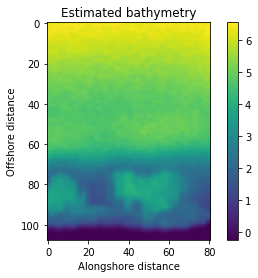

<Figure size 432x288 with 0 Axes>

In [11]:
title = 'Estimated bathymetry'
y_label = 'Offshore distance'
x_label = 'Alongshore distance'
file_name = 'DNN_bathy_Ens.jpg'

plot_im(y_mean, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

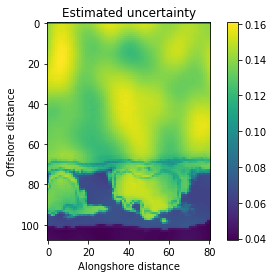

<Figure size 432x288 with 0 Axes>

In [12]:
title = 'Estimated uncertainty'
file_name = 'DNN_bathy_Ens_std.jpg'

plot_im(y_std, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

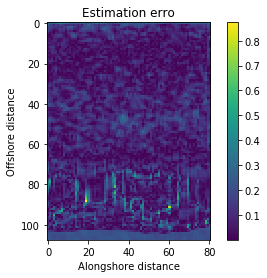

<Figure size 432x288 with 0 Axes>

In [14]:
title = 'Estimation erro'
file_name = 'DNN_bathy_Ens_Err.jpg'

plot_im(np.abs(y_test_ref - y_mean), [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
a = y_mean.reshape((108, 81))
b = y_test_ref.reshape((108, 81))
c = y_std.reshape((108,81))

In [ ]:
plt.plot(a[:,40])
plt.plot(b[:,40])
plt.plot(a[:,40]+2*c[:,40],'--')
plt.plot(a[:,40]-2*c[:,40],'--')

In [ ]:
savemat('UQ_DNN.mat',{'y_mean':y_mean,'y_std':y_std,'y_test_ref':y_test_ref})

In [ ]:
title = 'Estimated bathy'
file_name = 'DNN_bathy_Ens_Err.jpg'
plot_im(y_mean_id, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
plot_im(y_std_id, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimation erro'
file_name = 'DNN_bathy_Ens_Err.jpg'

plot_im(np.abs(y_test_ref - y_mean_id), [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
## Generate covariance matrix and it's cholescky factorization
L_div = 10
kernel = 'Gaussian'
#save_data = True
QQ, AA = generate_cov(L_div, kernel, save_data)


In [ ]:
b= np.dot(A, np.random.randn(9130,1))
plt.imshow(b.reshape((83,110)))
plt.colorbar()

In [ ]:
sig_pri = 1
y_mean, y_std, Post_Cov = network.get_std_mean_ens(forward_model, create_sub_samples, ref_bathy, n_ens, rec_len, A, nx, sig_pri,prior_cov = 'Gaussian', save_data = False)

In [ ]:
y_mean_id, y_std_id, Post_Cov_id = network.get_std_mean_ens(forward_model, create_sub_samples, ref_bathy, n_ens, rec_len, A, nx, sig_pri,prior_cov = 'Identity', save_data = False)

In [ ]:
title = 'Estimated bathymetry'
file_name = 'DNN_bathy_Ens_R1.jpg'

plot_im(y_mean, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimated uncertainty'
file_name = 'DNN_bathy_Ens_std_R1.jpg'

plot_im(y_std, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimation erro'
file_name = 'DNN_bathy_Ens_Err.jpg'

plot_im(np.abs(y_test_ref - y_mean), [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimated bathymetry'
file_name = 'DNN_bathy_Ens_R1.jpg'

plot_im(y_mean_id, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimated uncertainty'
file_name = 'DNN_bathy_Ens_std_R1.jpg'

plot_im(y_std_id, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
title = 'Estimation erro'
file_name = 'DNN_bathy_Ens_Err.jpg'

plot_im(np.abs(y_test_ref - y_mean_id), [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
network = DNN_Net.DNN_Net(X, Y, 4, [20,20,12,1], n_epoch = 3, Normalize = True, optimizer_meth = 'SGD', method = 'dropout', dropout = .2)

In [ ]:
Yt_hat = network.get_std_mean_MC_dropout(forward_model, create_sub_samples, ref_bathy, rec_len, nx, save_data = False)

In [ ]:
Y_drop = Yt_hat.squeeze()
Y_mean_drop = np.mean(Y_drop,axis=0)
std_drop = np.std(Y_drop, axis=0)

In [ ]:
#title = 'Estimated bathymetry'
#y_label = 'Offshore distance'
#x_label = 'Alongshore distance'
#file_name = 'DNN_bathy_Ens.jpg'

#plot_im(Y_mean_drop, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)
#plot_im(std_drop, [nx[1]-2, nx[0]-2], title, x_label, y_label, file_name, save_file = True)

In [ ]:
Yt_hat = network.get_std_mean_MC_dropout(forward_model, create_sub_samples, ref_bathy, rec_len, nx, save_data = False)

In [ ]:
c.shape